

## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



In [0]:
# Noisy data
# bart_simpson pic_0712.jpg

### Установка зависимостей

In [0]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [0]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [0]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [0]:
import random
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Функции

In [0]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [0]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [0]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [0]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()
        ##
        scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=2, gamma=0.5)#the initial lr decayed by gamma every step_size epochs
        ##

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            scheduler.step(val_loss)
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [0]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

## Класс

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} \\$,      константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [0]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode, augmentations):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode
        # аугментация
        self.augmentations = augmentations

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform_data = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
        ])
        
        #Augmenting images and ToTensor conversion
        transform_aug = transforms.Compose([
        #transforms.Normalize(mean= [-0.485/0.229, -0.456/0.224, -0.406/0.255],std= [1/0.229, 1/0.224, 1/0.255]),
        #Tensor denormalization   
#             transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(0.5),#probability=0.5
#             transforms.RandomVerticalFlip(0.1),#low probability 
#             transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.3, saturation=0.5)],p=0.5),
            transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.3, saturation=0.5),
                            transforms.RandomRotation(20)],p=0.5),
            transforms.ToTensor(),
#     transforms.RandomErasing(p=0.5, scale=(0.01, 0.01)),    
#             transforms.Normalize(mean=[0.485*255, 0.456*255, 0.406*255], std=[0.229, 0.224, 0.225])
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
#         x = np.array(np.array(x) / 255, dtype='float32') 
        if self.augmentations==False:        
            x = transform_data(x)
            if self.mode == 'test':
                return x
            else:
                label = self.labels[index]
                label_id = self.label_encoder.transform([label])
                y = label_id.item()
                return x,y
        else:
#             x = transform_aug(np.uint8(x))
            x = transform_aug(x)
            if self.mode == 'test':
                return x
            else:
                label = self.labels[index]
                label_id = self.label_encoder.transform([label])
                y = label_id.item()
                return x,y
                
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return image

In [0]:
# TRAIN_DIR = Path('train/dataset')
# TEST_DIR = Path('test/testset')
TRAIN_DIR = Path(r'C:\Users\ASUS\Documents\Python Scripts\MIPT\Kaggle homework\simpsons4\train\simpsons_dataset')
TEST_DIR = Path(r'C:\Users\ASUS\Documents\Python Scripts\MIPT\Kaggle homework\simpsons4\testset\testset')


train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [0]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

### Загрузка датасета

In [0]:
val_dataset = SimpsonsDataset(val_files, mode='val',augmentations = False)

In [0]:
train1_dataset = SimpsonsDataset(train_files, mode='train',augmentations = False)#add augmentations to train dataset
train_aug_dataset = SimpsonsDataset(train_files, mode='train',augmentations = True)
# train_dataset=train1_dataset
train_dataset=train1_dataset+train_aug_dataset

In [0]:
# imshow(train_dataset[501][0])

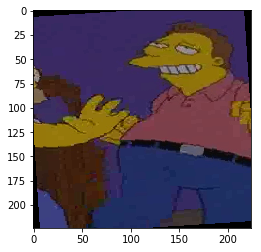

In [0]:
imshow(train_aug_dataset[1201][0])

Давайте посмотрим на наших героев внутри датасета.

In [0]:
# fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
#                         sharey=True, sharex=True)
# for fig_x in ax.flatten():
#     random_characters = int(np.random.uniform(0,1000))
#     im_val, label = val_dataset[random_characters]
#     img_label = " ".join(map(lambda x: x.capitalize(),\
#                 val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
#     imshow(im_val.data.cpu(), \
#           title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

Examples of augmentation results:

In [0]:
# samples = [train_dataset[id][0].unsqueeze(0) for id in list(map(int, np.arange(15600,15610)))]
# images_aug = [AUG(samples[i][0]) for i in range(len(samples))]

# fig=plt.figure(figsize=(12, 5))
# columns = 5
# rows = 2
# for i in range(len(samples)):
#     fig.add_subplot(rows, columns, i+1)
#     imshow(samples[i][0])
    
# fig=plt.figure(figsize=(12, 5))
# for i in range(len(images_aug)):
#     fig.add_subplot(rows, columns, i+1)
#     imshow(images_aug[i])

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [0]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=7,stride=2),
            nn.BatchNorm2d(96),
#             nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=2),
            nn.BatchNorm2d(256),
#             nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
#             nn.Dropout(p=0.5),
            nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
#             nn.Dropout(p=0.2),
            nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
#             nn.Dropout(p=0.5), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2)
        )
        
        self.fc1 = nn.Sequential(
            nn.Linear(256 * 5 * 5, 4096),
            nn.BatchNorm1d(4096),
            nn.Dropout(p=0.5),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(4096, 4096),
            nn.BatchNorm1d(4096),
            nn.Dropout(p=0.5),
            nn.ReLU()
        )
        
#         self.out = nn.Linear(96 * 5 * 5, n_classes)
        self.out = nn.Linear(4096, n_classes)
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
#         print(x.shape)
        x = x.view(x.size(0), -1)#reshape
        x = self.fc1(x)
        x = self.fc2(x)
        
        logits = self.out(x)
        return logits
    


In [0]:
# torch.cuda.empty_cache()

In [0]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)


print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
 

Запустим обучение сети.

In [0]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=5, batch_size=80)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 1.8061035720596372



Epoch 001 train_loss: 1.8061     val_loss 1.1244 train_acc 0.5232 val_acc 0.6892


epoch:  20%|██        | 1/5 [05:17<21:10, 317.52s/it]

loss 1.8158468775796575



Epoch 002 train_loss: 1.8158     val_loss 0.8862 train_acc 0.4955 val_acc 0.7433


epoch:  40%|████      | 2/5 [10:27<15:46, 315.37s/it]

loss 0.685636443670951



Epoch 003 train_loss: 0.6856     val_loss 0.6996 train_acc 0.8001 val_acc 0.8132


epoch:  60%|██████    | 3/5 [15:38<10:27, 313.85s/it]

loss 0.4219732986562907



Epoch 004 train_loss: 0.4220     val_loss 0.5518 train_acc 0.8712 val_acc 0.8539


epoch:  80%|████████  | 4/5 [20:46<05:12, 312.18s/it]

loss 0.2826098560019227



Epoch 005 train_loss: 0.2826     val_loss 0.4803 train_acc 0.9128 val_acc 0.8804


epoch: 100%|██████████| 5/5 [25:55<00:00, 311.30s/it]


Построим кривые обучения

In [0]:
loss, acc, val_loss, val_acc = zip(*history)

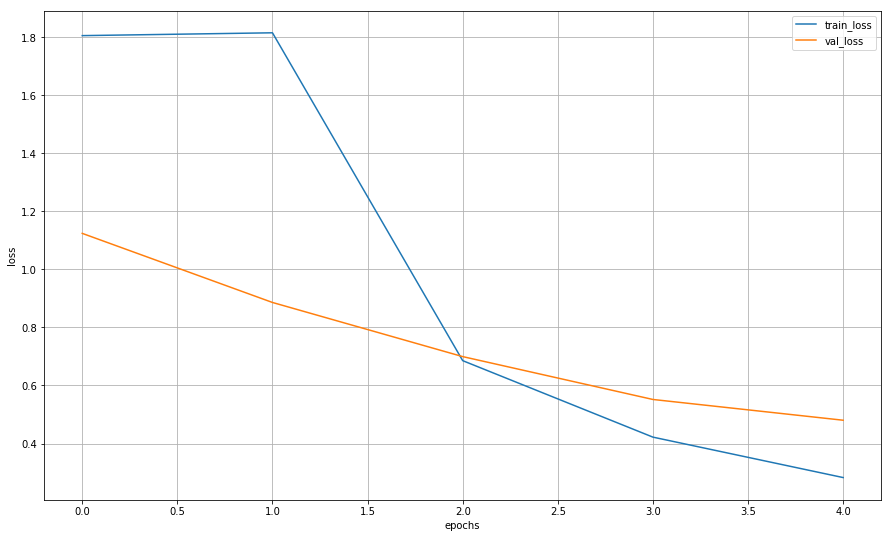

val losses: (1.1243960830065445, 0.8862001652248496, 0.6995783240428513, 0.5518179334337185, 0.4802558270372884)


In [0]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.grid()
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()
print('val losses:', val_loss)

val losses: (0.959287626256274, 0.6567144397337943, 0.6105444162725241, 0.6861095539577691, 0.6163830087343457, 0.6485417379194843, 0.6478903892389702)
val losses: (1.0914368933344716, 0.7984940418658556, 0.6164126302552182, 0.6298029569351216, 0.6859843797900584, 0.6651592476290953, 0.6560561642372514)
val losses: (1.0914368933344716, 0.7984940418658556, 0.6164126302552182, 0.6298029569351216, 0.6859843797900584, 0.6651592476290953, 0.6560561642372514)
val losses: (1.1752152132664495, 0.7360599387929018, 0.5752955068941442, 0.6368111739440195, 0.6259329512177155, 0.6837339642032847, 0.6601192717704357)

val losses: (1.1160038804178731, 0.7883509789555609, 0.6487771845128143, 0.684414439166729, 0.6363780808772271) 5epochs
+ 1 0.6781

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [0]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

Predict for one random image

In [0]:
random_characters = int(np.random.uniform(low=0,high=1000,size=1))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [0]:
imshow(ex_img.data.cpu())
plt.title(val_dataset.label_encoder.inverse_transform([true_label])[0])
print('Prediction: class',np.argmax(probs_im),'; name: ',val_dataset.label_encoder.inverse_transform([np.argmax(probs_im)])[0],
     '\nGround truth: class ',true_label,'; name: ',val_dataset.label_encoder.inverse_transform([true_label])[0])

Predict for 20 random images

In [0]:
idxs = list(map(int, np.random.uniform(low=0,high=1000, size=20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
probs_ims = predict(simple_cnn, imgs)

In [0]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [0]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [0]:
from sklearn.metrics import f1_score

In [0]:
f1_score(actual_labels, y_pred, average=None)

In [0]:
f1_score(actual_labels, y_pred, average='micro')

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

In [0]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [0]:
test_dataset = SimpsonsDataset(test_files, mode="test",augmentations=False)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [0]:
import pandas as pd

In [0]:
# my_submit = pd.read_csv("gdrive/My Drive/simpsons/data/labels.csv")
# my_submit = pd.read_csv(r"C:\Users\ASUS\Documents\Python Scripts\MIPT\Kaggle homework\simpsons4\sample_submission.csv")
# my_submit.head()

In [0]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

In [0]:
my_submit.tail()

In [0]:
my_submit.to_csv(r"C:\Users\ASUS\Documents\Python Scripts\MIPT\Kaggle homework\simpsons4/simple_cnn_baseline_third_try.csv", index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
